# LightGBM

In [49]:
import lightgbm as lgb

print(lgb.__version__) 

%load_ext autoreload
%autoreload 2

4.6.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# создаем dummy-dataset
import numpy as np, pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10_000, n_features=100, n_informative=60, random_state=911)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.23, shuffle=True, random_state=911)

tr = pd.DataFrame(X_tr, columns=['f_' + str(i) for i in range(X_tr.shape[1])], dtype=np.float32).assign(target=y_tr)
val = pd.DataFrame(X_val, columns=['f_' + str(i) for i in range(X_val.shape[1])], dtype=np.float32).assign(target=y_val)

features = tr.columns.drop('target')

tr.info()
tr.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Columns: 101 entries, f_0 to target
dtypes: float32(100), int32(1)
memory usage: 3.0 MB


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,target
0,-7.693210,-2.307856,1.330482,1.956519,-4.737048,-0.808857,-0.083493,-0.652450,-0.827025,2.895884,...,1.932500,-2.487015,0.531025,0.015999,3.841881,2.944531,-5.108033,-3.738099,0.668487,1
1,3.562736,2.726196,0.833317,0.382781,3.403235,0.835908,1.004829,2.453187,0.384746,0.400144,...,0.999936,0.831185,-8.842968,0.722457,6.440717,7.990329,-6.200291,2.575604,0.239539,0
2,1.181314,5.904849,0.574240,-1.499972,-2.565058,1.321400,-0.385923,4.773221,-0.879839,0.423675,...,-12.167426,-0.476589,-4.122464,-0.155873,-7.015498,0.609455,0.688230,-10.570615,-0.753206,1


### 1. sample code - делаем модельку

In [51]:
tr_lgb = lgb.Dataset(tr[features], tr.target)
val_lgb = lgb.Dataset(val[features], val.target)

params = {
    'objective': 'binary',
    'eta': 0.2,
    
    'metric': 'auc',
    'nthread': 32,
    'verbose': 0,
    'seed': 911
}

model = lgb.train(
    params, tr_lgb, num_boost_round=600,
    valid_sets=[val_lgb], callbacks=[lgb.early_stopping(20), lgb.log_evaluation(41)] # настройка early_stopping
)

y_raw = model.predict(val[features], raw_score=True) # так делать надо
y_prob = model.predict(val[features], raw_score=False) # по умолчанию False, но так делать не надо
print('y_raw:', y_raw[:5], '\ny_prob:', y_prob[:10].round(3))

Training until validation scores don't improve for 20 rounds
[41]	valid_0's auc: 0.965945
[82]	valid_0's auc: 0.976337
[123]	valid_0's auc: 0.981041
[164]	valid_0's auc: 0.98365
[205]	valid_0's auc: 0.984564
[246]	valid_0's auc: 0.985468
[287]	valid_0's auc: 0.986568
[328]	valid_0's auc: 0.986944
Early stopping, best iteration is:
[347]	valid_0's auc: 0.98721
y_raw: [-9.84991786  5.5639161  -6.75092681 16.05469397 -7.47068601] 
y_prob: [0.    0.996 0.001 1.    0.001 1.    0.    0.    0.    0.022]


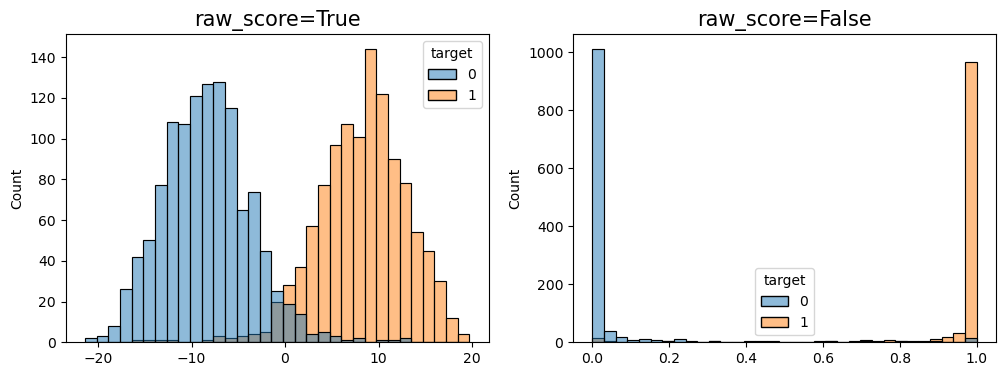

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('raw_score=True', fontsize=15)
sns.histplot(x=y_raw, hue=val.target, bins=33, ax=ax[0])
ax[1].set_title('raw_score=False', fontsize=15)
_ = sns.histplot(x=y_prob, hue=val.target, bins=33, ax=ax[1]) # log шкала спасает?


### 2. GOSS - работает ли?

In [53]:
from local_utils import make_subsample_test_fair
%load_ext autoreload
%autoreload 2

n_trees = [9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 25]
dif = []

for i in n_trees:
    plain, goss = make_subsample_test_fair(i)
    dif.append(plain - goss)
    print(f"n_trees = {i}, plain = {plain}, goss = {goss}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 6/6 [00:51<00:00,  8.63s/it]


n_trees = 9, plain = 13.870652198791504, goss = 16.608830213546753


 67%|██████▋   | 4/6 [00:10<00:05,  2.61s/it]


KeyboardInterrupt: 

Первое положительное значение в dif соответствует n_trees = 19


C:\Users\Admin\AppData\Local\Temp\ipykernel_54668\990372723.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=15)


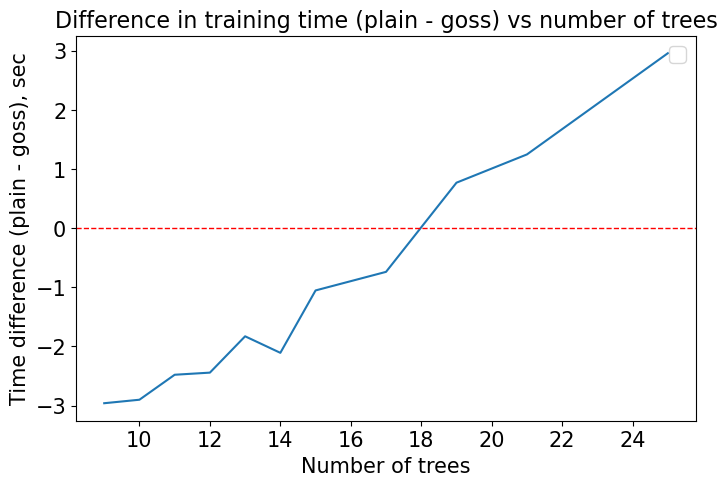

In [ ]:
import matplotlib.pyplot as plt

first_positive_index = next((index for index, value in enumerate(dif) if value > 0), None)

first_positive_n_trees = n_trees[first_positive_index]
print(f"Первое положительное значение в dif соответствует n_trees = {first_positive_n_trees}")


plt.plot(n_trees, dif)
plt.legend(fontsize=15)
plt.title('Difference in training time (plain - goss) vs number of trees', fontsize=16)
plt.gca().tick_params('both', labelsize=15)
plt.xlabel('Number of trees', fontsize=15)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero line')
plt.ylabel('Time difference (plain - goss), sec', fontsize=15)
plt.gcf().set_size_inches(8, 5)

И так уже третий год =)

### 3. linear_tree=True - насколько это быстро?

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


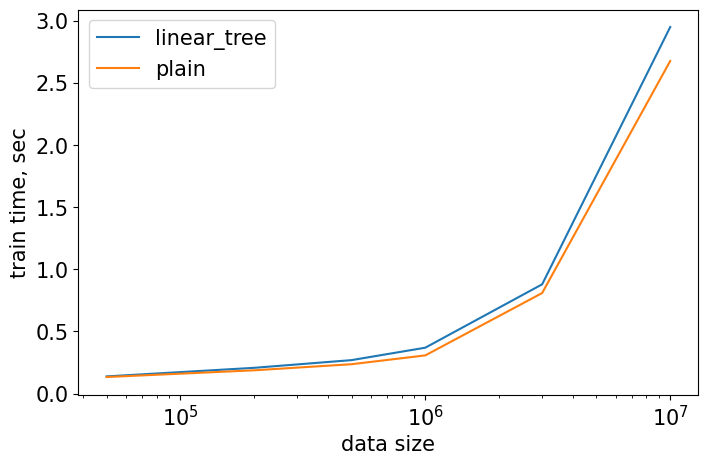

In [ ]:
from local_utils import make_linear_tree_test

make_linear_tree_test()

Это быстро)

### 4. quantized_grad=True - работает ли?

100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


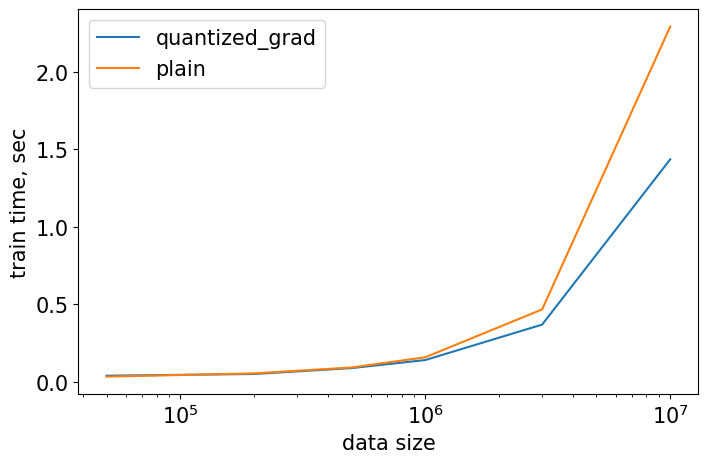

In [ ]:
from local_utils import make_quantized_grad_test

make_quantized_grad_test()

In [ ]:
from local_utils import make_quantized_grad_test_fair
%load_ext autoreload
%autoreload 2

n_trees_list = [10, 25, 50, 75, 100]
max_leaves_list = [80, 100, 128, 175, 200]

results = []

for n_trees in n_trees_list:
    for max_leaves in max_leaves_list:
        plain_time, quant_time = make_quantized_grad_test_fair(n_trees, max_leaves)
        
        results.append({
            'n_trees': n_trees,
            'max_leaves': max_leaves,
            'plain_time': plain_time,
            'quant_time': quant_time
        })
        
        print(f"n_trees = {n_trees}, max_leaves = {max_leaves}, plain_time = {plain_time}, quant_time = {quant_time}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 6/6 [00:20<00:00,  3.35s/it]


n_trees = 10, max_leaves = 80, plain_time = 6.436177492141724, quant_time = 7.451940059661865


100%|██████████| 6/6 [00:21<00:00,  3.61s/it]


n_trees = 10, max_leaves = 100, plain_time = 7.060253381729126, quant_time = 7.873751401901245


100%|██████████| 6/6 [00:23<00:00,  3.84s/it]


n_trees = 10, max_leaves = 128, plain_time = 7.530299425125122, quant_time = 8.529762744903564


100%|██████████| 6/6 [00:24<00:00,  4.14s/it]


n_trees = 10, max_leaves = 175, plain_time = 8.25061559677124, quant_time = 9.18243932723999


100%|██████████| 6/6 [00:25<00:00,  4.21s/it]


n_trees = 10, max_leaves = 200, plain_time = 8.361320972442627, quant_time = 9.383837938308716


100%|██████████| 6/6 [00:47<00:00,  7.87s/it]


n_trees = 25, max_leaves = 80, plain_time = 15.52425503730774, quant_time = 17.98030948638916


100%|██████████| 6/6 [00:51<00:00,  8.59s/it]


n_trees = 25, max_leaves = 100, plain_time = 17.049917936325073, quant_time = 19.930124521255493


100%|██████████| 6/6 [01:01<00:00, 10.19s/it]


n_trees = 25, max_leaves = 128, plain_time = 19.153998374938965, quant_time = 24.98650074005127


100%|██████████| 6/6 [01:13<00:00, 12.20s/it]


n_trees = 25, max_leaves = 175, plain_time = 25.188501119613647, quant_time = 25.60800051689148


100%|██████████| 6/6 [01:10<00:00, 11.82s/it]


n_trees = 25, max_leaves = 200, plain_time = 25.04850172996521, quant_time = 28.193500518798828


100%|██████████| 6/6 [01:45<00:00, 17.59s/it]


n_trees = 50, max_leaves = 80, plain_time = 35.43300151824951, quant_time = 37.98399901390076


100%|██████████| 6/6 [01:45<00:00, 17.61s/it]


n_trees = 50, max_leaves = 100, plain_time = 35.84900188446045, quant_time = 43.359498500823975


100%|██████████| 6/6 [01:52<00:00, 18.76s/it]


n_trees = 50, max_leaves = 128, plain_time = 37.708499908447266, quant_time = 41.7594997882843


100%|██████████| 6/6 [02:10<00:00, 21.73s/it]


n_trees = 50, max_leaves = 175, plain_time = 44.458497762680054, quant_time = 48.85800004005432


100%|██████████| 6/6 [02:10<00:00, 21.75s/it]


n_trees = 50, max_leaves = 200, plain_time = 46.63400101661682, quant_time = 51.42849826812744


100%|██████████| 6/6 [02:06<00:00, 21.08s/it]


n_trees = 75, max_leaves = 80, plain_time = 40.74549984931946, quant_time = 46.45349979400635


100%|██████████| 6/6 [02:22<00:00, 23.82s/it]


n_trees = 75, max_leaves = 100, plain_time = 48.6915020942688, quant_time = 51.08649969100952


100%|██████████| 6/6 [02:26<00:00, 24.33s/it]


n_trees = 75, max_leaves = 128, plain_time = 51.75100350379944, quant_time = 57.46599769592285


100%|██████████| 6/6 [02:41<00:00, 26.89s/it]


n_trees = 75, max_leaves = 175, plain_time = 52.86400079727173, quant_time = 65.59000015258789


100%|██████████| 6/6 [03:01<00:00, 30.19s/it]


n_trees = 75, max_leaves = 200, plain_time = 61.29400086402893, quant_time = 68.09849905967712


100%|██████████| 6/6 [02:30<00:00, 25.16s/it]


n_trees = 100, max_leaves = 80, plain_time = 52.45350217819214, quant_time = 50.21705675125122


100%|██████████| 6/6 [02:18<00:00, 23.16s/it]


n_trees = 100, max_leaves = 100, plain_time = 47.41397476196289, quant_time = 53.41790056228638


100%|██████████| 6/6 [02:25<00:00, 24.29s/it]


n_trees = 100, max_leaves = 128, plain_time = 50.19312572479248, quant_time = 55.8273241519928


100%|██████████| 6/6 [02:40<00:00, 26.71s/it]


n_trees = 100, max_leaves = 175, plain_time = 55.792908668518066, quant_time = 61.533976793289185


100%|██████████| 6/6 [02:44<00:00, 27.40s/it]

n_trees = 100, max_leaves = 200, plain_time = 56.53719139099121, quant_time = 62.895665645599365


In [56]:
from local_utils import make_quantized_grad_test_fair
%load_ext autoreload
%autoreload 2

n_trees_list = [3, 6, 10, 25, 50, 75, 100, 120, 140, 160, 200]
max_leaves_list = [10, 20, 40, 60, 80, 100, 128, 175, 200]

for n_trees in n_trees_list:
    for max_leaves in max_leaves_list:
        if not any(result['n_trees'] == n_trees and result['max_leaves'] == max_leaves for result in results):
            plain_time, quant_time = make_quantized_grad_test_fair(n_trees, max_leaves)
            
            results.append({
                'n_trees': n_trees,
                'max_leaves': max_leaves,
                'plain_time': plain_time,
                'quant_time': quant_time
            })
            
            print(f"n_trees = {n_trees}, max_leaves = {max_leaves}, plain_time = {plain_time}, quant_time = {quant_time}")
        else:
            print(f"n_trees = {n_trees}, max_leaves = {max_leaves} уже есть в results, пропускаем.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


n_trees = 3, max_leaves = 10, plain_time = 1.292027235031128, quant_time = 1.7060353755950928


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


n_trees = 3, max_leaves = 20, plain_time = 1.548044204711914, quant_time = 1.945000410079956


100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


n_trees = 3, max_leaves = 40, plain_time = 1.832077980041504, quant_time = 2.2831053733825684


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


n_trees = 3, max_leaves = 60, plain_time = 2.051898956298828, quant_time = 2.5245518684387207


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


n_trees = 3, max_leaves = 80, plain_time = 2.2211086750030518, quant_time = 2.6655941009521484


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


n_trees = 3, max_leaves = 100, plain_time = 2.3695690631866455, quant_time = 2.850975275039673


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


n_trees = 3, max_leaves = 128, plain_time = 2.5640645027160645, quant_time = 3.0576202869415283


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


n_trees = 3, max_leaves = 175, plain_time = 2.7500414848327637, quant_time = 3.2522103786468506


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


n_trees = 3, max_leaves = 200, plain_time = 2.900353193283081, quant_time = 3.328115940093994


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


n_trees = 6, max_leaves = 10, plain_time = 2.088132381439209, quant_time = 2.6756680011749268


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


n_trees = 6, max_leaves = 20, plain_time = 2.592834711074829, quant_time = 3.1548609733581543


100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


n_trees = 6, max_leaves = 40, plain_time = 3.202951431274414, quant_time = 3.848979949951172


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


n_trees = 6, max_leaves = 60, plain_time = 3.6572728157043457, quant_time = 4.298186779022217


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


n_trees = 6, max_leaves = 80, plain_time = 4.045776844024658, quant_time = 4.693345308303833


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


n_trees = 6, max_leaves = 100, plain_time = 4.346059322357178, quant_time = 4.969632387161255


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


n_trees = 6, max_leaves = 128, plain_time = 4.6430504322052, quant_time = 5.314716100692749


100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


n_trees = 6, max_leaves = 175, plain_time = 5.0190110206604, quant_time = 5.719496011734009


100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


n_trees = 6, max_leaves = 200, plain_time = 5.195663690567017, quant_time = 5.8771584033966064


100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


n_trees = 10, max_leaves = 10, plain_time = 3.0886707305908203, quant_time = 3.839092969894409


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


n_trees = 10, max_leaves = 20, plain_time = 3.9799962043762207, quant_time = 4.73236870765686


100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


n_trees = 10, max_leaves = 40, plain_time = 5.0966103076934814, quant_time = 5.838779449462891


100%|██████████| 6/6 [00:18<00:00,  3.08s/it]


n_trees = 10, max_leaves = 60, plain_time = 5.772879123687744, quant_time = 6.616817951202393
n_trees = 10, max_leaves = 80 уже есть в results, пропускаем.
n_trees = 10, max_leaves = 100 уже есть в results, пропускаем.
n_trees = 10, max_leaves = 128 уже есть в results, пропускаем.
n_trees = 10, max_leaves = 175 уже есть в results, пропускаем.
n_trees = 10, max_leaves = 200 уже есть в results, пропускаем.


100%|██████████| 6/6 [00:23<00:00,  3.89s/it]


n_trees = 25, max_leaves = 10, plain_time = 7.171550512313843, quant_time = 8.30661654472351


100%|██████████| 6/6 [00:29<00:00,  4.91s/it]


n_trees = 25, max_leaves = 20, plain_time = 9.164865255355835, quant_time = 10.625464916229248


100%|██████████| 6/6 [00:37<00:00,  6.18s/it]


n_trees = 25, max_leaves = 40, plain_time = 12.073386430740356, quant_time = 13.637546062469482


100%|██████████| 6/6 [00:41<00:00,  6.94s/it]


n_trees = 25, max_leaves = 60, plain_time = 13.79229187965393, quant_time = 15.467484474182129
n_trees = 25, max_leaves = 80 уже есть в results, пропускаем.
n_trees = 25, max_leaves = 100 уже есть в results, пропускаем.
n_trees = 25, max_leaves = 128 уже есть в results, пропускаем.
n_trees = 25, max_leaves = 175 уже есть в results, пропускаем.
n_trees = 25, max_leaves = 200 уже есть в results, пропускаем.


100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


n_trees = 50, max_leaves = 10, plain_time = 12.069431781768799, quant_time = 14.520569324493408


100%|██████████| 6/6 [00:50<00:00,  8.40s/it]


n_trees = 50, max_leaves = 20, plain_time = 15.873018741607666, quant_time = 18.887187957763672


100%|██████████| 6/6 [01:06<00:00, 11.04s/it]


n_trees = 50, max_leaves = 40, plain_time = 21.515958309173584, quant_time = 25.168501377105713


100%|██████████| 6/6 [01:14<00:00, 12.48s/it]


n_trees = 50, max_leaves = 60, plain_time = 25.25861167907715, quant_time = 28.085801124572754
n_trees = 50, max_leaves = 80 уже есть в results, пропускаем.
n_trees = 50, max_leaves = 100 уже есть в results, пропускаем.
n_trees = 50, max_leaves = 128 уже есть в results, пропускаем.
n_trees = 50, max_leaves = 175 уже есть в results, пропускаем.
n_trees = 50, max_leaves = 200 уже есть в results, пропускаем.


100%|██████████| 6/6 [00:54<00:00,  9.06s/it]


n_trees = 75, max_leaves = 10, plain_time = 16.29876685142517, quant_time = 20.567856073379517


100%|██████████| 6/6 [01:09<00:00, 11.63s/it]


n_trees = 75, max_leaves = 20, plain_time = 22.206629276275635, quant_time = 26.171393156051636


100%|██████████| 6/6 [01:29<00:00, 14.93s/it]


n_trees = 75, max_leaves = 40, plain_time = 28.831730604171753, quant_time = 34.62727355957031


100%|██████████| 6/6 [01:39<00:00, 16.51s/it]


n_trees = 75, max_leaves = 60, plain_time = 33.55137658119202, quant_time = 37.39239525794983
n_trees = 75, max_leaves = 80 уже есть в results, пропускаем.
n_trees = 75, max_leaves = 100 уже есть в results, пропускаем.
n_trees = 75, max_leaves = 128 уже есть в results, пропускаем.
n_trees = 75, max_leaves = 175 уже есть в results, пропускаем.
n_trees = 75, max_leaves = 200 уже есть в results, пропускаем.


100%|██████████| 6/6 [01:08<00:00, 11.41s/it]


n_trees = 100, max_leaves = 10, plain_time = 20.685139894485474, quant_time = 26.14901089668274


100%|██████████| 6/6 [01:28<00:00, 14.69s/it]


n_trees = 100, max_leaves = 20, plain_time = 28.008750438690186, quant_time = 33.37085938453674


100%|██████████| 6/6 [01:50<00:00, 18.36s/it]


n_trees = 100, max_leaves = 40, plain_time = 35.71024775505066, quant_time = 42.17641067504883


100%|██████████| 6/6 [02:00<00:00, 20.12s/it]


n_trees = 100, max_leaves = 60, plain_time = 40.18769454956055, quant_time = 45.56388854980469
n_trees = 100, max_leaves = 80 уже есть в results, пропускаем.
n_trees = 100, max_leaves = 100 уже есть в results, пропускаем.
n_trees = 100, max_leaves = 128 уже есть в results, пропускаем.
n_trees = 100, max_leaves = 175 уже есть в results, пропускаем.
n_trees = 100, max_leaves = 200 уже есть в results, пропускаем.


100%|██████████| 6/6 [01:19<00:00, 13.26s/it]


n_trees = 120, max_leaves = 10, plain_time = 24.099398136138916, quant_time = 30.512290239334106


100%|██████████| 6/6 [01:41<00:00, 16.93s/it]


n_trees = 120, max_leaves = 20, plain_time = 31.612367153167725, quant_time = 39.07298278808594


100%|██████████| 6/6 [02:05<00:00, 20.90s/it]


n_trees = 120, max_leaves = 40, plain_time = 40.72549510002136, quant_time = 48.60200834274292


100%|██████████| 6/6 [02:15<00:00, 22.65s/it]


n_trees = 120, max_leaves = 60, plain_time = 45.65988326072693, quant_time = 51.7196261882782


100%|██████████| 6/6 [02:25<00:00, 24.21s/it]


n_trees = 120, max_leaves = 80, plain_time = 48.45807957649231, quant_time = 56.07017421722412


100%|██████████| 6/6 [02:27<00:00, 24.60s/it]


n_trees = 120, max_leaves = 100, plain_time = 52.566025257110596, quant_time = 52.2754442691803


100%|██████████| 6/6 [02:43<00:00, 27.22s/it]


n_trees = 120, max_leaves = 128, plain_time = 56.28394937515259, quant_time = 62.173504114151


100%|██████████| 6/6 [03:00<00:00, 30.02s/it]


n_trees = 120, max_leaves = 175, plain_time = 62.52360820770264, quant_time = 69.49019646644592


100%|██████████| 6/6 [03:03<00:00, 30.66s/it]


n_trees = 120, max_leaves = 200, plain_time = 64.58102083206177, quant_time = 69.49878334999084


100%|██████████| 6/6 [01:31<00:00, 15.30s/it]


n_trees = 140, max_leaves = 10, plain_time = 27.67845606803894, quant_time = 34.73307180404663


100%|██████████| 6/6 [01:55<00:00, 19.21s/it]


n_trees = 140, max_leaves = 20, plain_time = 36.11359357833862, quant_time = 44.33028984069824


100%|██████████| 6/6 [02:20<00:00, 23.39s/it]


n_trees = 140, max_leaves = 40, plain_time = 45.56844234466553, quant_time = 54.375587463378906


100%|██████████| 6/6 [02:33<00:00, 25.53s/it]


n_trees = 140, max_leaves = 60, plain_time = 51.40450716018677, quant_time = 58.57874035835266


100%|██████████| 6/6 [02:42<00:00, 27.03s/it]


n_trees = 140, max_leaves = 80, plain_time = 54.93507385253906, quant_time = 61.5609176158905


100%|██████████| 6/6 [02:51<00:00, 28.63s/it]


n_trees = 140, max_leaves = 100, plain_time = 57.927289724349976, quant_time = 66.43492460250854


100%|██████████| 6/6 [03:01<00:00, 30.28s/it]


n_trees = 140, max_leaves = 128, plain_time = 61.74124836921692, quant_time = 70.4201889038086


100%|██████████| 6/6 [03:17<00:00, 32.89s/it]


n_trees = 140, max_leaves = 175, plain_time = 68.33524346351624, quant_time = 75.85500359535217


100%|██████████| 6/6 [03:19<00:00, 33.26s/it]


n_trees = 140, max_leaves = 200, plain_time = 68.30190420150757, quant_time = 76.23863625526428


100%|██████████| 6/6 [01:43<00:00, 17.18s/it]


n_trees = 160, max_leaves = 10, plain_time = 31.266358852386475, quant_time = 39.73415732383728


100%|██████████| 6/6 [02:08<00:00, 21.42s/it]


n_trees = 160, max_leaves = 20, plain_time = 40.1337411403656, quant_time = 49.28756904602051


100%|██████████| 6/6 [02:34<00:00, 25.76s/it]


n_trees = 160, max_leaves = 40, plain_time = 49.10459303855896, quant_time = 59.46491813659668


100%|██████████| 6/6 [02:49<00:00, 28.17s/it]


n_trees = 160, max_leaves = 60, plain_time = 56.373374938964844, quant_time = 64.90625


100%|██████████| 6/6 [03:04<00:00, 30.77s/it]


n_trees = 160, max_leaves = 80, plain_time = 61.88138794898987, quant_time = 71.86687278747559


 83%|████████▎ | 5/6 [01:44<00:20, 20.88s/it]


KeyboardInterrupt: 

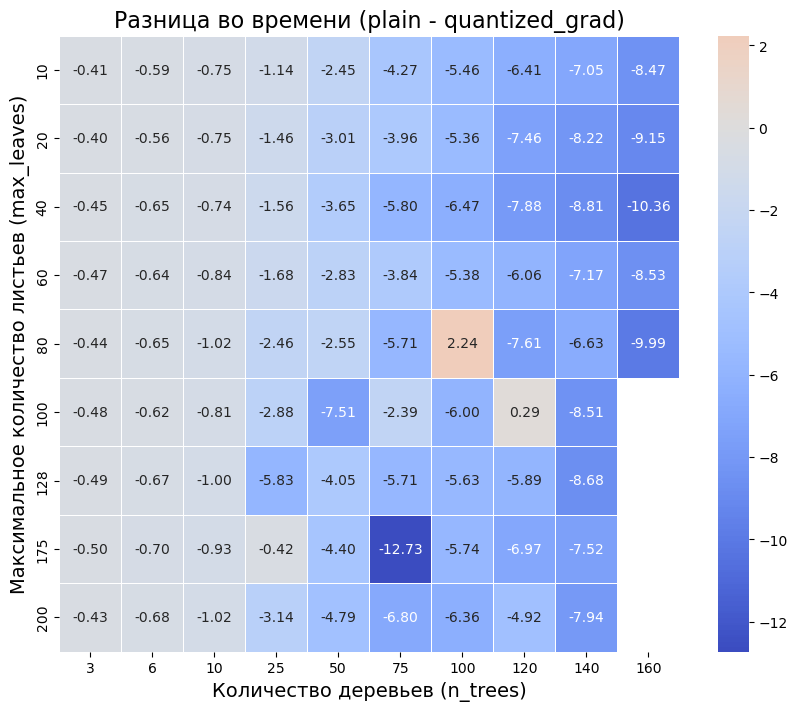

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

df['time_diff'] = df['plain_time'] - df['quant_time']

pivot_table = df.pivot(index='max_leaves', columns='n_trees', values='time_diff')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title('Разница во времени (plain - quantized_grad)', fontsize=16)
plt.xlabel('Количество деревьев (n_trees)', fontsize=14)
plt.ylabel('Максимальное количество листьев (max_leaves)', fontsize=14)
plt.show()

Не особо)

In [ ]:
1

### 5. DART - насколько это быстро?

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.31s/it]


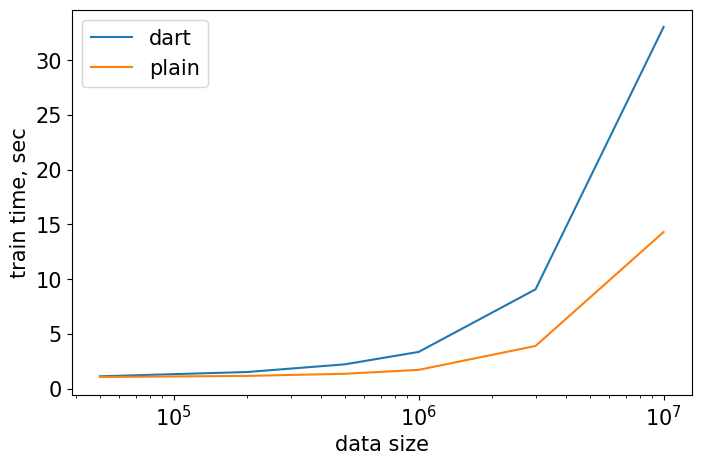

In [ ]:
from local_utils import make_dart_test

make_dart_test()

Не особо)

### 6. eta - шокирующая правда!

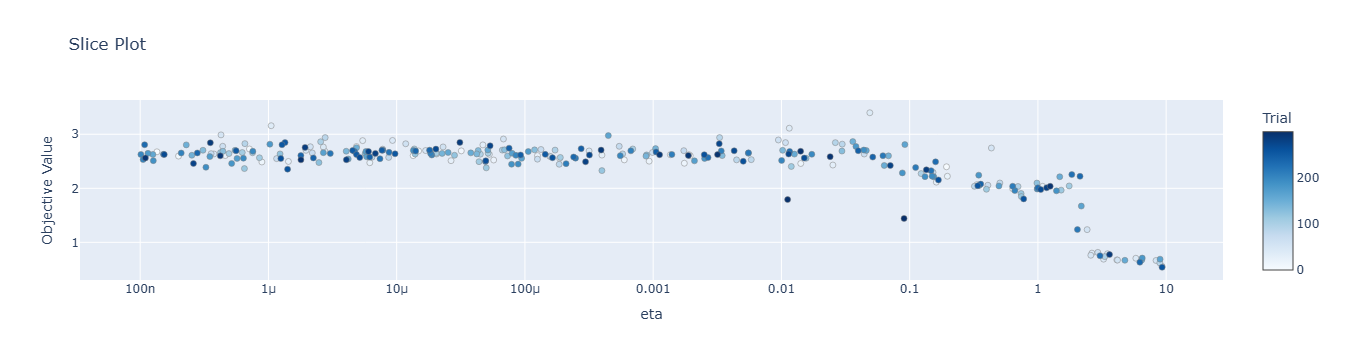

In [ ]:
from local_utils import make_eta_test
from optuna.visualization import plot_slice

# 0.005, 1
study = make_eta_test()
plot_slice(study)